# COMP90051 Project 2

In [2]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## 1. Implement ε-Greedy and UCB

In [3]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """

In [4]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, epsilon, Q0=np.inf):
        if narms < 1 or not isinstance(narms, int):
            raise AssertionError('narms should be positive integer')
        if not 0.0 <= epsilon <= 1.0:
            raise AssertionError('invalid probability')
        if not isinstance(Q0, (int, float)):
            raise AssertionError('not real-valued Q0')
            
        self.narms = narms
        self.__epsilon = epsilon
        self.__counts = [0] * narms # arm counts
        self.__Q = [Q0] * narms # Q value
        self.__X = [0.0] * narms # reward count
        
    def play(self, tround, context=None):
        if tround < 1 or not isinstance(tround, int):
            raise AssertionError('tround should be positive integer')
            
        arm = None
        if np.random.random() > self.__epsilon:
            arm = np.random.choice(np.argwhere(self.__Q == np.max(self.__Q)).flatten().
                                   tolist()) #exploitation with tie breaking
        else:
            arm = np.random.randint(self.narms) #exploration
            
        return arm + 1
        
    def update(self, arm, reward, context=None):
        if not 1 <= arm <= self.narms:
            raise AssertionError('arm should be in between 1 and ' + str(self.narms))
        if not isinstance(arm, (np.int32, int)):
            raise AssertionError('arm should be positive integer')
        if not isinstance(reward, float):
            raise AssertionError('reward should be floating point number')
        
        arm = arm - 1
        # update arm count
        self.__counts[arm] = self.__counts[arm] + 1
        # update reward
        self.__X[arm] = self.__X[arm] + reward
        # update Q value
        self.__Q[arm] = self.__X[arm] / self.__counts[arm]

In [5]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, rho, Q0=np.inf):
        if narms < 1 or not isinstance(narms, int):
            raise AssertionError('narms should be positive integer')
        if not rho > 0.0:
            raise AssertionError('positive real rho expected')
        if not isinstance(Q0, (int, float)):
            raise AssertionError('not real-valued Q0')
            
        self.narms = narms
        self.__rho = rho
        self.__counts = [0] * narms # arms count
        self.__Q = [Q0] * narms # Q value
        self.__X = [0.0] * narms # rewards count
    
    def play(self, tround, context=None):
        if tround < 1 or not isinstance(tround, int):
            raise AssertionError('tround should be positive integer')
            
        for i in range(0, self.narms):
            if self.__counts[i] > 0:
                exploitation = self.__X[i] / self.__counts[i] # mu_t_1
                exploration = np.sqrt((self.__rho * np.log(tround)) / self.__counts[i])
                self.__Q[i] = exploitation + exploration
            
        return np.random.choice(np.argwhere(self.__Q == np.max(self.__Q)).flatten().tolist()) + 1
        
    def update(self, arm, reward, context=None):
        if not 1 <= arm <= self.narms:
            raise AssertionError('arm should be in between 1 and ' + str(self.narms))
        if not isinstance(arm, (np.int32, int)):
            raise AssertionError('arm should be positive integer')
        if not isinstance(reward, float):
            raise AssertionError('reward should be floating point number')
        
        arm = arm - 1
        #update arm count
        self.__counts[arm] = self.__counts[arm] + 1
        #update reward
        self.__X[arm] = self.__X[arm] + reward

## 2. Off-Policy Evaluation

In [6]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    
    if not ((arms >= 1).all() and (arms <= mab.narms).all()):
        raise AssertionError('invalid array arms of values. The range should be from 1 to '+ str(mab.narms))
    if not (all(np.asarray([np.isscalar(x) for x in rewards]))):
        raise AssertionError('an array of scalar numeric rewards expected')
    if not len(arms) == len(rewards):
        raise AssertionError('rewards and arms array size mismatches')
    if not np.isreal(contexts).all():
        raise AssertionError('a numeric 2D array contexts expected')
    if not contexts.shape[0] == arms.shape[0]:
        raise AssertionError('The number of rows in context array should be equal to the number of narms')
    if not contexts.shape[1] % mab.narms == 0:
        raise AssertionError('The number of columns of context array should be equal to a positive multiple of mab narms')
    if nrounds < 1 or not isinstance(nrounds, int):
            raise AssertionError('nrounds should be positive integer')
        
    tround = 0
    reward_history = list()
    for i in range(0, len(arms)):
        if tround < nrounds:
            arm = mab.play(tround + 1, contexts[i])
            if arm == arms[i]:
                mab.update(arm, rewards[i], contexts[i])
                reward_history.append(rewards[i])
                tround = tround + 1
        else:
            break
        
    return reward_history

In [7]:
data = np.loadtxt('dataset.txt')
arms, rewards, contexts = data[:,0], data[:, 1], data[:,2:102]

In [8]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.18


In [17]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.18125


## 3. Contextual Bandits

In [10]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, alpha):
        if narms < 1 or not isinstance(narms, int):
            raise AssertionError('narms should be positive integer')
        if ndims < 1 or not isinstance(ndims, int):
            raise AssertionError('ndims should be positive integer')
        if not alpha > 0.0:
            raise AssertionError('alpha should be positive real-valued')

        self.narms = narms
        self.alpha = alpha
        self.A = [np.eye(ndims, dtype = float)] * narms
        self.b = [np.zeros((ndims, 1))] * narms
        
    def play(self, tround, context):
        if tround < 1 or not isinstance(tround, int):
            raise AssertionError('tround should be positive integer')
            
        P = [0.0] * self.narms
        for i in range(0, self.narms):
            A_inv =inv(self.A[i])
            x_a = context[i * 10 : (i * 10) + 10].reshape(-1,1)
            theta = np.dot(A_inv, self.b[i])
            exploitation = np.dot(theta.T, x_a)
            exploration = self.alpha * np.sqrt(np.dot(np.dot(x_a.T, A_inv), x_a))
            P[i] = np.asscalar(exploitation + exploration)
            
        return np.random.choice(np.argwhere(P == np.max(P)).flatten().tolist()) + 1
    
    def update(self, arm, reward, context):
        if not 1 <= arm <= self.narms:
            raise AssertionError('arm should be in between 1 and' + str(self.narms))
        if not isinstance(arm, (np.int32, int)):
            raise AssertionError('arm should be positive integer')
        if not isinstance(reward, float):
            raise AssertionError('reward should be floating point number')
            
        arm = arm - 1
        x_a = context[arm * 10 : (arm * 10) + 10].reshape(-1,1)
        self.A[arm] = self.A[arm] + np.dot(x_a, x_a.T)
        self.b[arm] = self.b[arm] + reward * x_a

In [19]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.53


## 4. Evaluation
### 4.A.

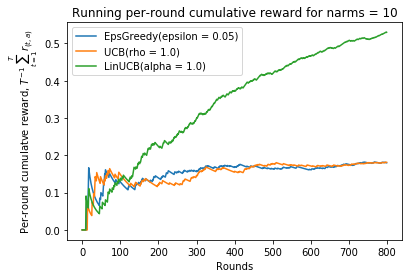

In [20]:
rounds = np.linspace(1, 800, 800, endpoint=True)
plt.plot(np.cumsum(results_EpsGreedy) / rounds, label = 'EpsGreedy(epsilon = 0.05)')
plt.plot(np.cumsum(results_UCB) / rounds, label = 'UCB(rho = 1.0)')
plt.plot(np.cumsum(results_LinUCB) / rounds, label = 'LinUCB(alpha = 1.0)')
plt.ylabel('Per-round cumulatve reward, $T^{-1}$'+'$\sum_{t=1}^T r_{(t,a)}$')
plt.xlabel('Rounds')
plt.title('Running per-round cumulative reward for narms = 10')
plt.legend()

### 4.B.

Text(0.5,0,'alphas')

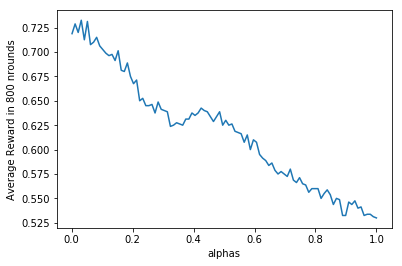

In [132]:
alphas = np.linspace(0.001, 1.0, 100)
greed_search = list()
for alpha in alphas:
    greed_search.append(np.mean(offlineEvaluate(LinUCB(10, 10, alpha), arms, rewards, contexts, 800)))
plt.plot(alphas, greed_search, label = 'LinUCB')
plt.ylabel('Average Reward in 800 nrounds')
plt.xlabel('alphas')

In [126]:
maxValue = max(greed_search)
bestAlpha = [a for a, v in zip(alphas, greed_search) if v == maxValue]
print ("best alpha", bestAlpha, maxValue)

best alpha [0.03127272727272727] 0.7325


## 5. KernelUCB

In [11]:
# Do not edit. Special import for this section.
from sklearn.metrics.pairwise import rbf_kernel

In [21]:
class KernelUCB(MAB):
    """
    Kernelised contextual multi-armed bandit (Kernelised LinUCB)
    
    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    gamma : float
        positive real explore-exploit parameter
    
    eta : float
        positive real explore-exploit parameter
    
    kern : callable
        a kernel function from sklearn.metrics.pairwise
    """
    def __init__(self, narms, ndims, gamma, eta, kern):
        self.narms = narms
        self.d = ndims
        self.gamma = gamma
        self.eta = eta
        self.kern = kern
        self.y = [] #reward history
        self.x = [] #context history
        self.K_inv = None #Kernel Inverse Matrix
        
    def play(self, tround, context):
        mu = [0.0] * self.narms
        
        if tround == 1:
            mu[0] = 1.0
        else:
            contexts = context.reshape(self.narms,self.d)
            k_x_t = self.kern(contexts, np.reshape(self.x,(len(self.x),self.d)))
            y_t = np.reshape(self.y, (1, tround-1)).T
            for n in range(0, self.narms):
                x_t = contexts[n].reshape(1, -1) # take the arm feature
                k_x_n_t = k_x_t[n].reshape(tround - 1, 1) # get the kernel value
                Kxt_Kinv = np.dot(k_x_n_t.T, self.K_inv)
                sigma = np.asscalar(np.sqrt(self.kern(x_t, x_t) - np.dot(Kxt_Kinv, k_x_n_t)))
                mu[n] = np.asscalar(np.dot(Kxt_Kinv, y_t)) + (self.eta/np.sqrt(self.gamma)) * sigma
        
        arm = np.random.choice(np.argwhere(mu == np.max(mu)).flatten().tolist())
        
        return arm + 1
    
    def update(self, arm, reward, context):
        arm = arm - 1
        self.y.append(reward) # Take the reward
        
        #get the context and save
        x_t = context.reshape(self.narms,self.d)[arm].reshape(1,-1) 
        self.x.append(x_t)
        
        # calculate K_inv
        tround = len(self.x)
        if tround == 1:
            self.K_inv = 1.0 / (self.kern(x_t, x_t) + self.gamma)
        else:
            k_x_t = self.kern(x_t, np.reshape(self.x,(len(self.x),self.d))).ravel() # calculate the Kernel
            b = k_x_t[0:tround-1].reshape(tround-1, 1) # get b vector
            Kinv = self.K_inv # get last K_inv matrix
            # calculate K_inv for current round
            bKinv = np.dot(b.T,Kinv)
            Kinvb = np.dot(Kinv,b)
            K22 = 1.0/(self.kern(x_t, x_t) + self.gamma - np.dot(bKinv,b))
            K11 = Kinv + K22 * np.dot(Kinvb, bKinv)
            K12 = - np.asscalar(K22) * Kinvb
            K21 = - np.asscalar(K22) * bKinv
#             print ("tround: ", tround, "K11", K11.shape, "K12", K12.shape, "K21",K21.shape, "K22",K22.shape)
            self.K_inv = np.vstack((np.hstack((K11,K12)),np.hstack((K21,K22))))

#### Grid Search for KernelUCB

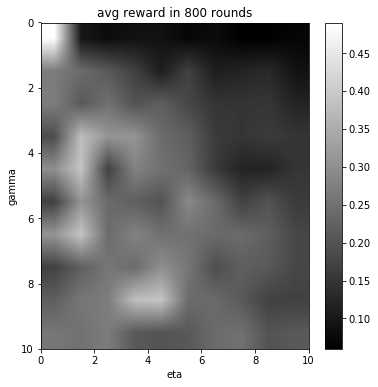

In [37]:
def z_func(gammas, etas, n):
    Z = np.zeros((len(gammas),len(etas)))
    for i, x in enumerate(gammas):
        for j, y in enumerate(etas):
            mab = KernelUCB(10, 10, x, y, rbf_kernel)
            results_mab = offlineEvaluate(mab, arms, rewards, contexts, n)
            Z[i, j] = np.mean(results_mab)
    return Z

start1 = 0.01
end1 = 10.0
n = 800
gammas = np.linspace(start1, end1, 10)
etas = np.linspace(.01, 10.0, 10)
Z = z_func(gammas, etas, 100)
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(Z, cmap ='gray', interpolation='bilinear', extent=[min(etas),max(etas),end1,start1], aspect="auto")
plt.colorbar(im)
plt.ylabel('gamma')
plt.xlabel('eta')
plt.title('avg reward in '+ str(n) +' rounds')
plt.show()

#### Compare KernelUCB with LinUCB

In [22]:
mab = KernelUCB(10, 10, 1.0, 1.0, rbf_kernel)
results_KernelUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('KernelUCB average reward', np.mean(results_KernelUCB))

KernelUCB average reward 0.59


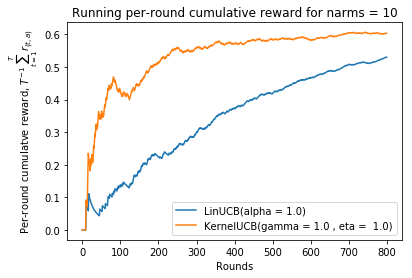

In [107]:
plt.plot(np.cumsum(results_LinUCB) / rounds, label = 'LinUCB(alpha = 1.0)')
plt.plot(np.cumsum(results_KernelUCB) / rounds, label = 'KernelUCB(gamma = 1.0 , eta =  1.0)')
plt.ylabel('Per-round cumulatve reward, $T^{-1}$'+'$\sum_{t=1}^T r_{(t,a)}$')
plt.xlabel('Rounds')
plt.title('Running per-round cumulative reward for narms = 10')
plt.legend()